In [1]:
import warnings
warnings.filterwarnings('ignore')

<h1>Importing</h1>

In [2]:
import torch.nn as nn
import random
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid", font_scale=1.5, rc={"axes.unicode_minus":False})

import torch
import torchmetrics
from torch import optim
from torch.nn import functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

import lightning.pytorch as pl
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

# Data processing and loading
from data_preprocessing import train_loader, val_loader, temp_val_loader, train_dataset

# Set random seeds for reproducibility
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
pl.seed_everything(seed)

Seed set to 1


1

<h1>Visualization</h1>

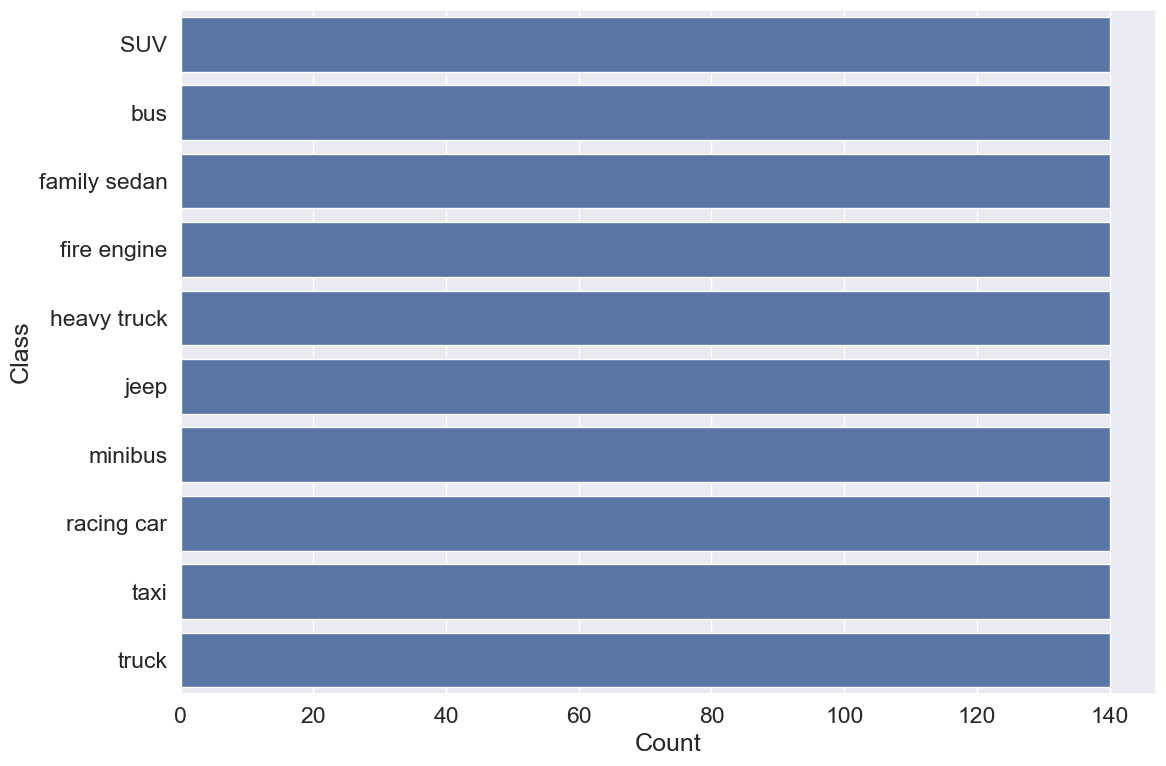

In [3]:
class_names = train_dataset.classes
class_count = [train_dataset.targets.count(i) for i in range(len(class_names))]
df = pd.DataFrame({"Class": class_names, "Count": class_count})

plt.figure(figsize=(12, 8), dpi=100)
sns.barplot(x="Count", y="Class", data=df)
plt.tight_layout()
plt.show()

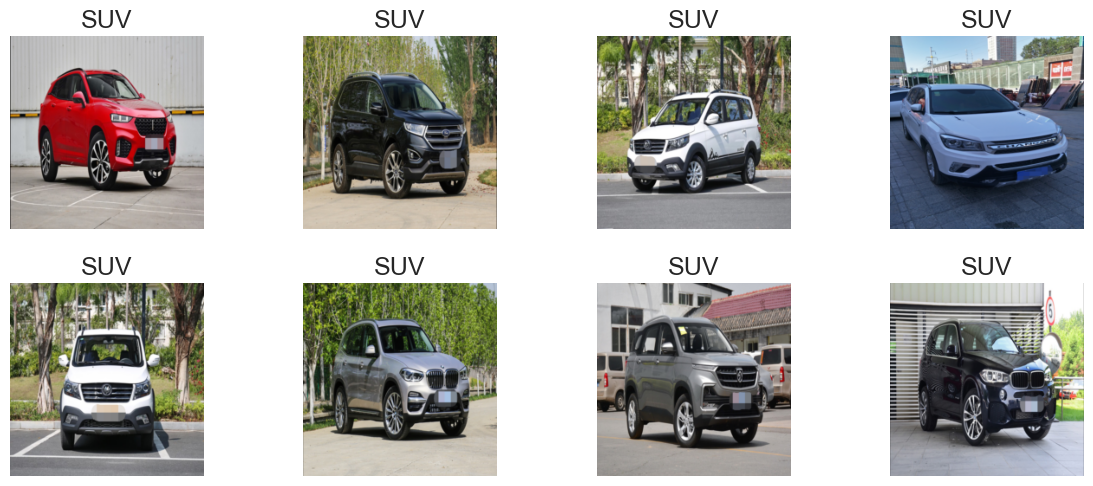

In [4]:
plt.figure(figsize=(12, 20), dpi=100)
# quickly grab a batch of data from the validation loader
images, labels = next(iter(temp_val_loader))
for i in range(8):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(images[i].permute(1, 2, 0).numpy())
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.tight_layout()
plt.show()

<h1>Modeling</h1>

In [5]:
class LitModel(pl.LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(512 * 3 * 3, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

        def forward(self, x):
            x = self.fc(x)
            return x

    def training_step(self, batch, batch_idx):
        x, y = batch 
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.accuracy(torch.argmax(y_hat, dim=1), y)  # Use argmax for accuracy calculation
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=0.0005, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.3)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',
            }
        }

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.accuracy(torch.argmax(y_hat, dim=1), y)  # Use argmax for accuracy calculation
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        acc = self.accuracy(torch.argmax(y_hat, dim=1), y)  # Use argmax for accuracy calculation
        self.log('test_acc', acc)

    def predict_step(self, batch, batch_idx):
        x, _ = batch  # Targets are not needed for predictions
        y_hat = self(x)
        preds = torch.argmax(y_hat, dim=1)
        return preds

<h5>Train the model or ...</h5>

In [7]:
num_classes = len(class_names)
model = LitModel(num_classes=num_classes)
logger = CSVLogger("../")
early_stop_callback = EarlyStopping(monitor="val_loss", patience=5, mode="min")
checkpoint_callback = ModelCheckpoint(monitor='val_acc', save_top_k=1, mode='max')

trainer = pl.Trainer(
    max_epochs=50,
    enable_progress_bar=True,
    log_every_n_steps=10,
    logger=logger,
    callbacks=[early_stop_callback, checkpoint_callback], 
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1 if torch.cuda.is_available() else None
)


trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                      | Params | Mode 
---------------------------------------------------------------
0 | model    | CustomCNNFeatureExtractor | 3.9 M  | train
1 | accuracy | MulticlassAccuracy        | 0      | train
---------------------------------------------------------------
3.9 M     Trainable params
0         Non-trainable params
3.9 M     Total params
15.763    Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 44/44 [00:29<00:00,  1.52it/s, v_num=0]          
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1:   0%|          | 0/44 [00:00<?, ?it/s, v_num=0, val_acc=0.525, train_loss=2.020]         


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

<h5>Load The Trained Model</h5>

In [15]:
# checkpoint_path = checkpoint_callback.best_model_path

checkpoint_path = "../lightning_logs/version_12/checkpoints/epoch=24-step=1100.ckpt"

# Load the model from the checkpoint
model = LitModel.load_from_checkpoint(checkpoint_path)

# Save the model
torch.save(model.state_dict(), "vehicle_classifier_customcnn.pt")

In [18]:
trainer = pl.Trainer(
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1 if torch.cuda.is_available() else None
)

trainer.test(model, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 7/7 [00:02<00:00,  2.97it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9100000262260437
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.9100000262260437}]

<h1>Predict Test Data<h1>

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:02<00:00,  2.76it/s] 


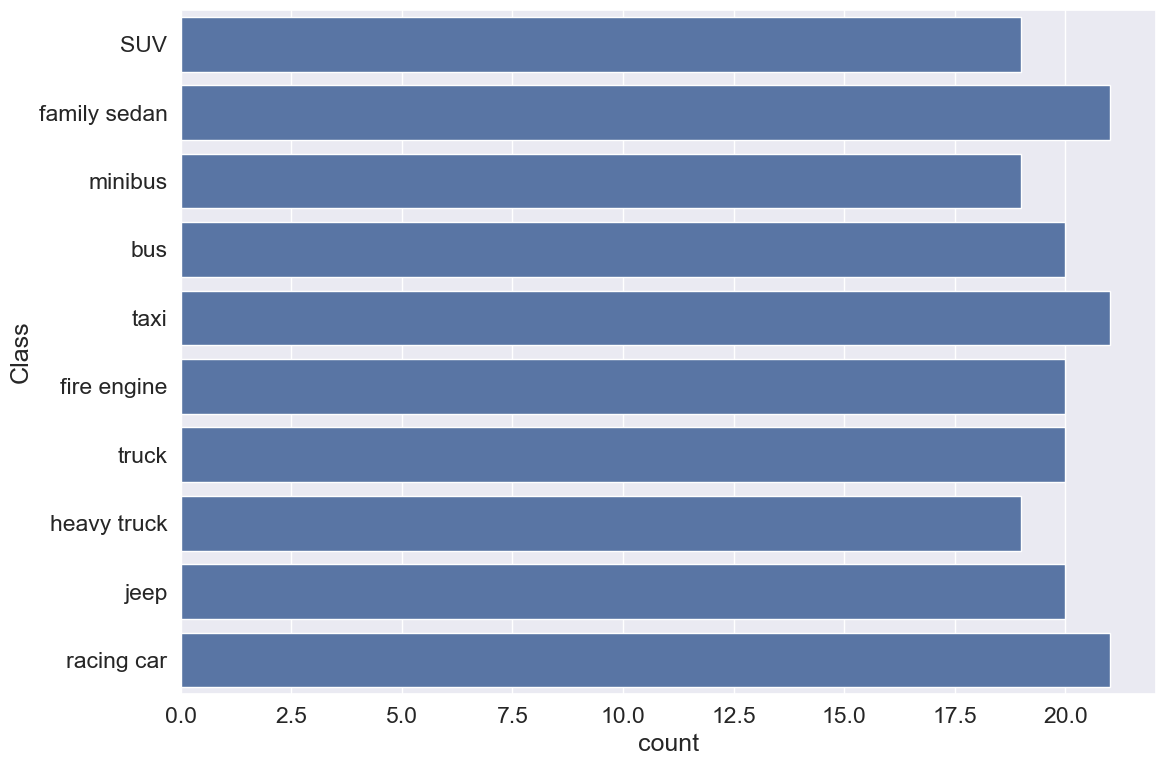

In [19]:
pred = trainer.predict(model, val_loader)
pred = torch.cat(pred, dim=0)
pred = pd.DataFrame(pred.numpy(), columns=["Class"])
pred["Class"] = pred["Class"].apply(lambda x: class_names[x])

plt.figure(figsize=(12, 8), dpi=100)
sns.countplot(y="Class", data=pred)
plt.tight_layout()
plt.show()

<h1>Loss & Accuracy</h1>

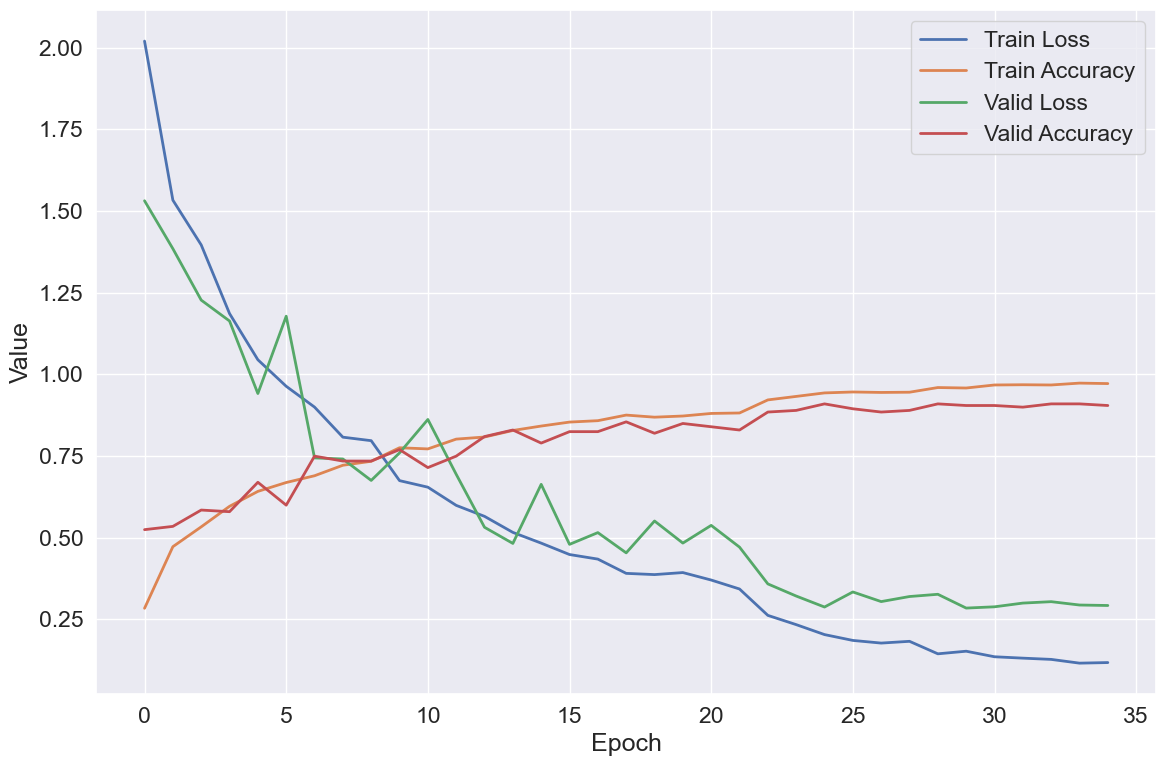

In [22]:
metrics_path = Path(logger.log_dir) / "metrics.csv"
metrics = pd.read_csv("../lightning_logs/version_12/metrics.csv")

plt.figure(figsize=(12, 8), dpi=100)
sns.lineplot(x="epoch", y="train_loss", data=metrics, label="Train Loss", linewidth=2)
sns.lineplot(x="epoch", y="train_acc", data=metrics, label="Train Accuracy", linewidth=2)
sns.lineplot(x="epoch", y="val_loss", data=metrics, label="Valid Loss", linewidth=2)
sns.lineplot(x="epoch", y="val_acc", data=metrics, label="Valid Accuracy", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.tight_layout()
plt.show()